<h3><center>Introduction</center></h3>
<div style="font-family:verdana; word-spacing:1.7px;">
    The CrowdSource team at Google Research, a group dedicated to advancing NLP and other types of ML science via crowdsourcing, has collected data on a number of quality scoring aspects.
<br><br>
In this Kernel, we will use this new dataset to build predictive algorithms for different subjective aspects of question-answering. The question-answer pairs were gathered from nearly 70 different websites, in a "common-sense" fashion.<br><br>
    </div>

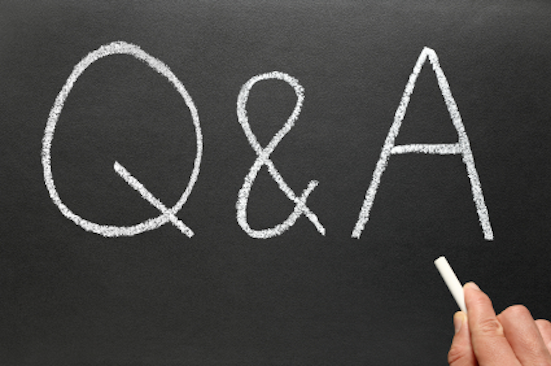

<h3><center>1. Importing Libraries</center></h3>

In [1]:
!pip install -q textstat

In [2]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np 
import pandas as pd 
import os
import gc

from tqdm import tqdm, tqdm_notebook
tqdm_notebook().pandas()

from matplotlib_venn import venn2, venn3, venn2_circles, venn3_circles 
import matplotlib.pyplot as plt 
import seaborn as sns

import plotly.offline as plty
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.figure_factory as ff

from scipy import stats
import textstat

from nltk import word_tokenize
from nltk.sentiment.vader import SentimentIntensityAnalyzer

from sklearn.model_selection import GroupKFold
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

import tensorflow as tf
import tensorflow.keras.backend as K
from scipy.stats import spearmanr
from math import floor, ceil

from wordcloud import WordCloud, STOPWORDS


0it [00:00, ?it/s]

<h3><center>2. Reading Files</center></h3>

In [3]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/google-quest-challenge/sample_submission.csv
/kaggle/input/google-quest-challenge/train.csv
/kaggle/input/google-quest-challenge/test.csv


In [4]:
PATH = '/kaggle/input/google-quest-challenge/'

train_df = pd.read_csv(f'{PATH}train.csv')
test_df = pd.read_csv(f'{PATH}test.csv')

<h3><center>3. Exploring Data</center></h3>

In [5]:
def DataDesc(df):
    print(f"Dataset Shape: {df.shape}")
    summary = pd.DataFrame(df.dtypes,columns=['dtypes'])
    summary = summary.reset_index()
    summary['Name'] = summary['index']
    summary = summary[['Name','dtypes']]
    summary['Missing'] = df.isnull().sum().values    
    summary['Uniques'] = df.nunique().values
    summary['First Value'] = df.loc[0].values
    summary['Second Value'] = df.loc[1].values
    summary['Third Value'] = df.loc[2].values

    for name in summary['Name'].value_counts().index:
        summary.loc[summary['Name'] == name, 'Entropy'] = round(stats.entropy(df[name].value_counts(normalize=True), base=2),2) 
    
    return summary

In [6]:
DataDesc(train_df)[:10]

Dataset Shape: (6079, 41)


Name  dtypes  Missing  Uniques  \
0               qa_id   int64        0     6079   
1      question_title  object        0     3583   
2       question_body  object        0     3583   
3  question_user_name  object        0     3215   
4  question_user_page  object        0     3422   
5              answer  object        0     6079   
6    answer_user_name  object        0     4114   
7    answer_user_page  object        0     4430   
8                 url  object        0     3583   
9            category  object        0        5   

                                         First Value  \
0                                                  0   
1  What am I losing when using extension tubes in...   
2  After playing around with macro photography on...   
3                                               ysap   
4         https://photo.stackexchange.com/users/1024   
5  I just got extension tubes, so here's the skin...   
6                                             rfusca   
7         https://photo.stackexchange.com/users/1917   
8  http://photo.stackexchange.com/questions/9169/...   
9                                          LIFE_ARTS   

                                        Second Value  \
0                                                  1   
1  What is the distinction between a city and a s...   
2  I am trying to understand what kinds of places...   
3                                      russellpierce   
4           https://rpg.stackexchange.com/users/8774   
5  It might be helpful to look into the definitio...   
6                                       Erik Schmidt   
7           https://rpg.stackexchange.com/users/1871   
8  http://rpg.stackexchange.com/questions/47820/w...   
9                                            CULTURE   

                                         Third Value  Entropy  
0                                                  2    12.57  
1  Maximum protusion length for through-hole comp...    11.64  
2  I'm working on a PCB that has through-hole com...    11.64  
3                                          Joe Baker    11.42  
4  https://electronics.stackexchange.com/users/10157    11.56  
5  Do you even need grooves?  We make several pro...    12.57  
6                                        Dwayne Reid    11.68  
7  https://electronics.stackexchange.com/users/64754    11.85  
8  http://electronics.stackexchange.com/questions...    11.64  
9                                            SCIENCE     2.14

The data looks pretty clean with no missing values.

In [7]:
DataDesc(test_df)[:10]

Dataset Shape: (476, 11)


Name  dtypes  Missing  Uniques  \
0               qa_id   int64        0      476   
1      question_title  object        0      476   
2       question_body  object        0      476   
3  question_user_name  object        0      467   
4  question_user_page  object        0      474   
5              answer  object        0      476   
6    answer_user_name  object        0      363   
7    answer_user_page  object        0      367   
8                 url  object        0      476   
9            category  object        0        5   

                                         First Value  \
0                                                 39   
1  Will leaving corpses lying around upset my pri...   
2  I see questions/information online about how t...   
3                                              Dylan   
4       https://gaming.stackexchange.com/users/64471   
5  There is no consequence for leaving corpses an...   
6                                          Nelson868   
7       https://gaming.stackexchange.com/users/97324   
8  http://gaming.stackexchange.com/questions/1979...   
9                                            CULTURE   

                                        Second Value  \
0                                                 46   
1         Url link to feature image in the portfolio   
2  I am new to Wordpress. i have issue with Featu...   
3                                                Anu   
4    https://wordpress.stackexchange.com/users/72927   
5  I think it is possible with custom fields.\n\n...   
6                                              Irina   
7    https://wordpress.stackexchange.com/users/27233   
8  http://wordpress.stackexchange.com/questions/1...   
9                                         TECHNOLOGY   

                                         Third Value  Entropy  
0                                                 70     8.89  
1  Is accuracy, recoil or bullet spread affected ...     8.89  
2  To experiment I started a bot game, toggled in...     8.89  
3                                             Konsta     8.85  
4       https://gaming.stackexchange.com/users/37545     8.89  
5  You do not have armour in the screenshots. Thi...     8.89  
6                                     Damon Smithies     8.38  
7       https://gaming.stackexchange.com/users/70641     8.41  
8  http://gaming.stackexchange.com/questions/2154...     8.89  
9                                            CULTURE     2.09

<h3>Target Columns</h3>

In [8]:
sub_df = pd.read_csv(f'{PATH}sample_submission.csv')
target_cols = train_df[train_df.columns[train_df.columns.isin(sub_df.columns[1:])]].columns

In [9]:
target_cols

Index(['question_asker_intent_understanding', 'question_body_critical',
       'question_conversational', 'question_expect_short_answer',
       'question_fact_seeking', 'question_has_commonly_accepted_answer',
       'question_interestingness_others', 'question_interestingness_self',
       'question_multi_intent', 'question_not_really_a_question',
       'question_opinion_seeking', 'question_type_choice',
       'question_type_compare', 'question_type_consequence',
       'question_type_definition', 'question_type_entity',
       'question_type_instructions', 'question_type_procedure',
       'question_type_reason_explanation', 'question_type_spelling',
       'question_well_written', 'answer_helpful',
       'answer_level_of_information', 'answer_plausible', 'answer_relevance',
       'answer_satisfaction', 'answer_type_instructions',
       'answer_type_procedure', 'answer_type_reason_explanation',
       'answer_well_written'],
      dtype='object')

In [10]:
train_df.host[:5]

0            photo.stackexchange.com
1              rpg.stackexchange.com
2      electronics.stackexchange.com
3          judaism.stackexchange.com
4    graphicdesign.stackexchange.com
Name: host, dtype: object

In [11]:
train_df.category.value_counts()

TECHNOLOGY       2441
STACKOVERFLOW    1253
CULTURE           963
SCIENCE           713
LIFE_ARTS         709
Name: category, dtype: int64

Splitting and fetching first string to indentfiy the category

In [12]:
train_df['host_cat'] = train_df['host'].apply(lambda x : x.split('.')[0])
train_df.drop(['host'], axis=1, inplace=True)

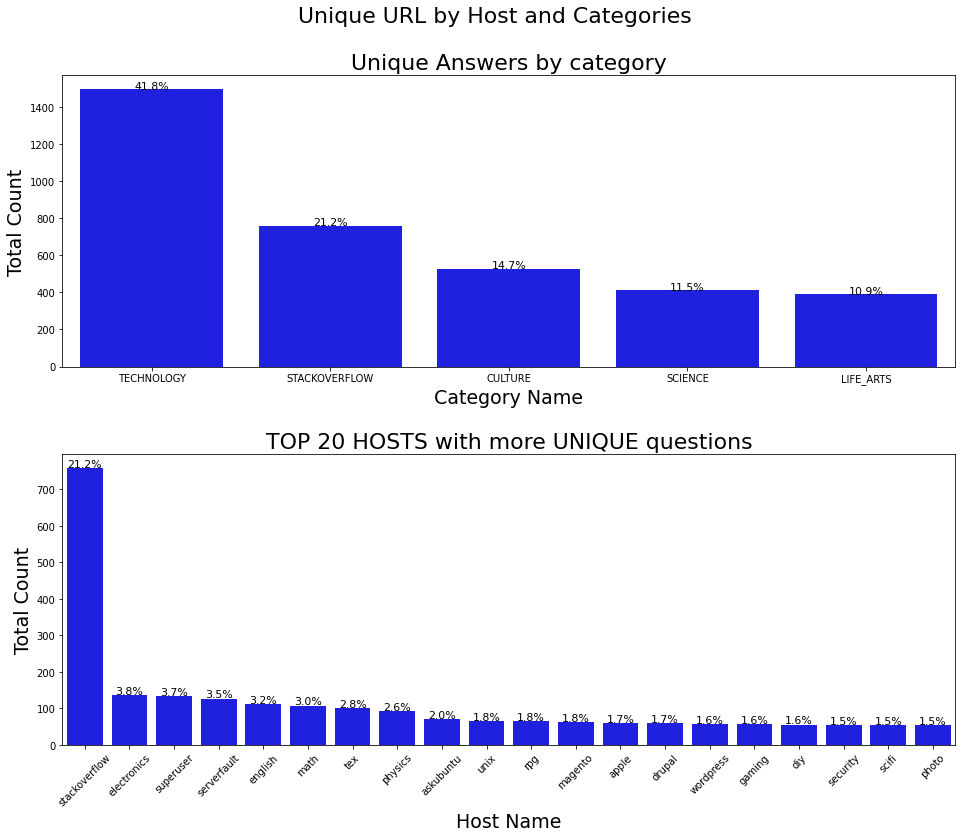

In [13]:
host = train_df.groupby(['host_cat'])['url'].nunique().sort_values(ascending=False)
category = train_df.groupby(['category'])['url'].nunique().sort_values(ascending=False)

plt.figure(figsize=(16,12))
plt.suptitle('Unique URL by Host and Categories', size=22)

plt.subplot(211)
g0 = sns.barplot(x=category.index, y=category.values, color='blue')
g0.set_title("Unique Answers by category", fontsize=22)
g0.set_xlabel("Category Name", fontsize=19)
g0.set_ylabel("Total Count", fontsize=19)
#g1.set_xticklabels(g1.get_xticklabels(),rotation=45)
for p in g0.patches:
    height = p.get_height()
    g0.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.1f}%'.format(height/category.sum()*100),
            ha="center",fontsize=11) 

plt.subplot(212)
g1 = sns.barplot(x=host[:20].index, y=host[:20].values, color='blue')
g1.set_title("TOP 20 HOSTS with more UNIQUE questions", fontsize=22)
g1.set_xlabel("Host Name", fontsize=19)
g1.set_ylabel("Total Count", fontsize=19)
g1.set_xticklabels(g1.get_xticklabels(),rotation=45)
for p in g1.patches:
    height = p.get_height()
    g1.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.1f}%'.format(height/host.sum()*100),
            ha="center",fontsize=11) 
    
plt.subplots_adjust(hspace = 0.3, top = 0.90)

plt.show()

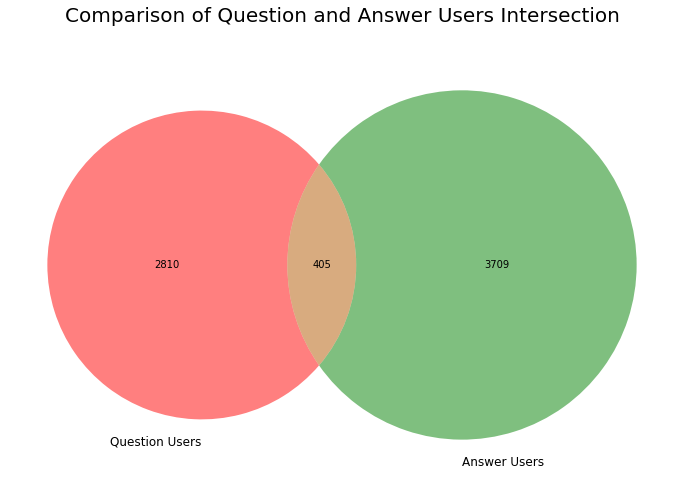

In [14]:
plt.figure(figsize=(12,8))

venn2([set(train_df['question_user_name'].values), 
       set(train_df['answer_user_name'].values)],
      set_labels=('Question Users', 'Answer Users'), alpha=.5)

plt.title('Comparison of Question and Answer Users Intersection\n', fontsize=20)

plt.show()

* We can see that 405 users have played role in both questioning & answering sessions.
* We have more users who have answered than the questions asked as multiple users might have responded

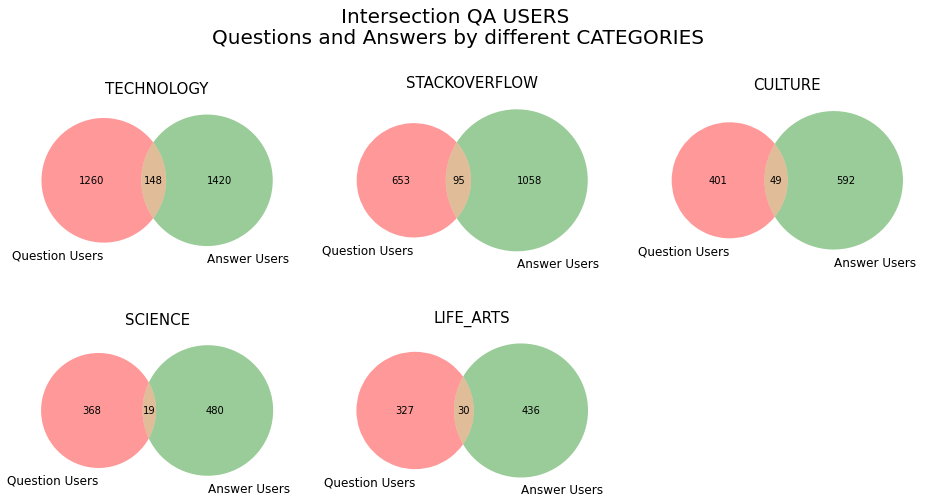

In [15]:
import matplotlib.gridspec as gridspec # to do the grid of plots

grid = gridspec.GridSpec(3, 3)
plt.figure(figsize=(16,3*4))

plt.suptitle('Intersection QA USERS \nQuestions and Answers by different CATEGORIES', size=20)

for n, col in enumerate(set(train_df['category'].values)):
    ax = plt.subplot(grid[n])
    venn2([set(train_df[train_df.category == col]['question_user_name'].values), 
           set(train_df[train_df.category == col]['answer_user_name'].values)],
      set_labels=('Question Users', 'Answer Users'), )
    ax.set_title(str(col), fontsize=15)
    ax.set_xlabel('')
    #plt.subplots_adjust(top = 0.98, wspace=.9, hspace=.9)
    
plt.subplots_adjust(top = 0.9, hspace=.1)

plt.show()

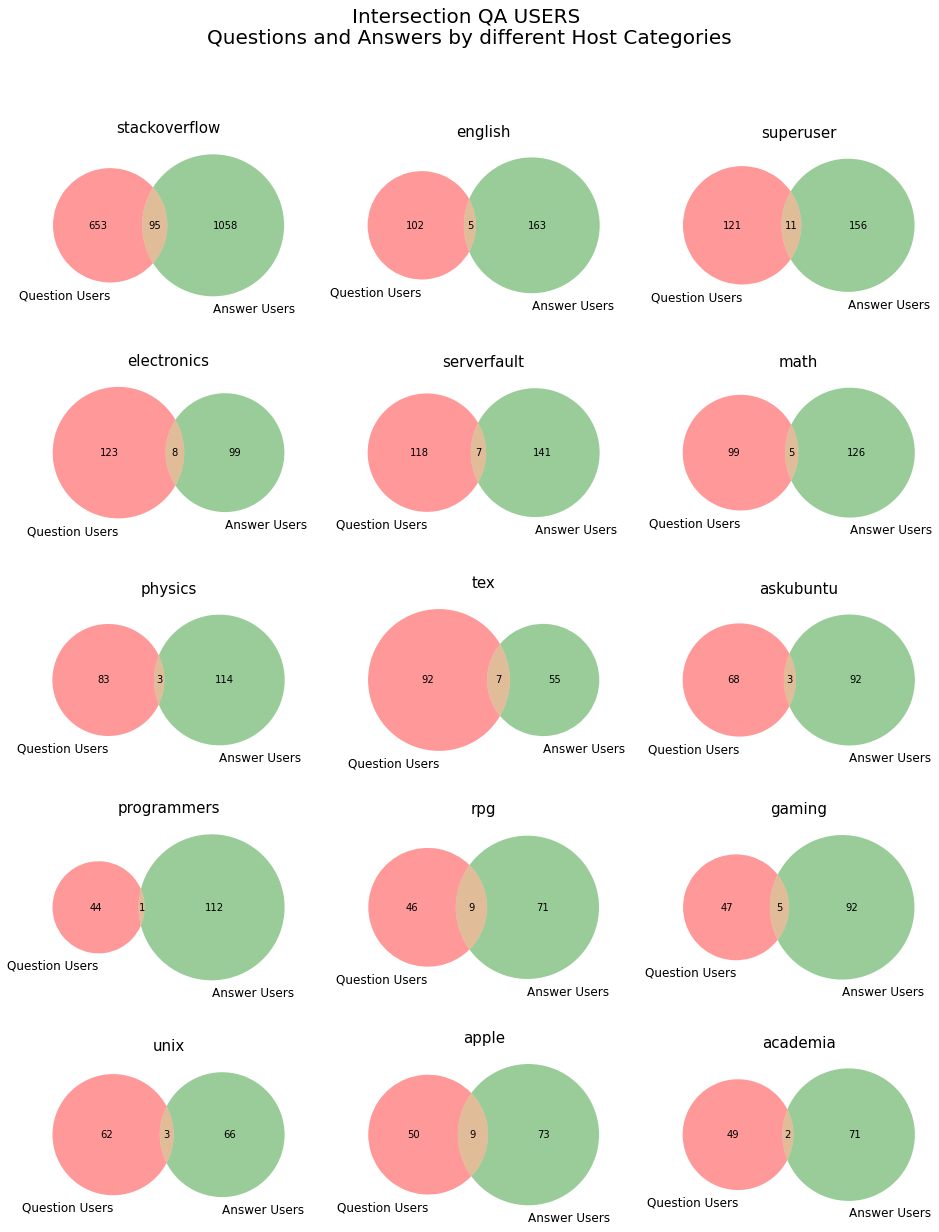

In [16]:
grid = gridspec.GridSpec(5, 3)
plt.figure(figsize=(16,5*4))

top_cat = train_df['host_cat'].value_counts(ascending=False).index[:15]

plt.suptitle('Intersection QA USERS \nQuestions and Answers by different Host Categories', size=20)

for n, col in enumerate(top_cat):
    ax = plt.subplot(grid[n])
    venn2([set(train_df[train_df.host_cat == col]['question_user_name'].values), 
           set(train_df[train_df.host_cat == col]['answer_user_name'].values)],
      set_labels=('Question Users', 'Answer Users'), )
    ax.set_title(str(col), fontsize=15)
    ax.set_xlabel('')
    #plt.subplots_adjust(top = 0.98, wspace=.9, hspace=.9)
    
plt.subplots_adjust(top = 0.9, hspace=.1)

plt.show()

<h3>No of Words in body</h3>

In [17]:
question_body_tokens = [word_tokenize(question) for question in train_df.question_body.values]

len_words = []

for i in range(len(question_body_tokens)):
    len_words.append(len(question_body_tokens[i]))
    
# Create a new feature for the lengh of each review
train_df['question_n_words'] = len_words

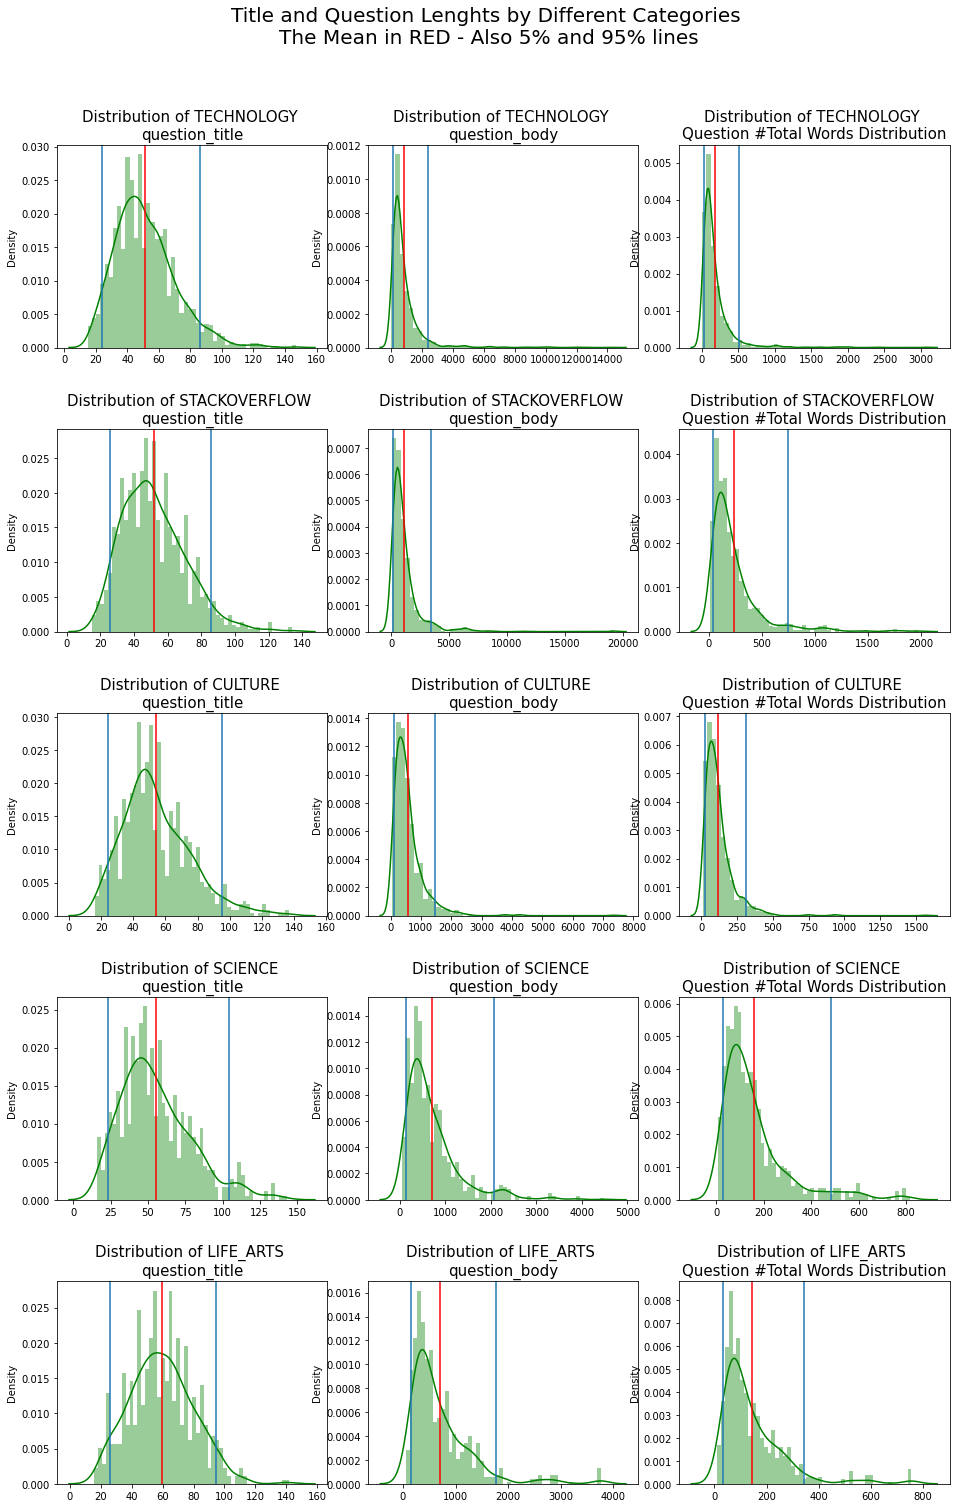

In [18]:
grid = gridspec.GridSpec(5, 3)
plt.figure(figsize=(16,6*4))

plt.suptitle('Title and Question Lenghts by Different Categories \nThe Mean in RED - Also 5% and 95% lines', size=20)
count=0
top_cats=train_df['category'].value_counts().index
for n, col in enumerate(top_cats):
    for i, q_t in enumerate(['question_title', 'question_body', 'question_n_words']):
        ax = plt.subplot(grid[count])
        if q_t == 'question_n_words':
            sns.distplot(train_df[train_df['category'] == col][q_t], bins = 50, 
                         color='g', label="RED - 50%") 
            ax.set_title(f"Distribution of {str(col)} \nQuestion #Total Words Distribution", fontsize=15)
            ax.axvline(train_df[train_df['category'] == col][q_t].quantile(.95))
            ax.axvline(train_df[train_df['category'] == col][q_t].quantile(.05))
            mean_val = train_df[train_df['category'] == col][q_t].mean()
            ax.axvline(mean_val, color='red' )
            ax.set_xlabel('')            
        else:
            sns.distplot(train_df[train_df['category'] == col][q_t].str.len(), bins = 50, 
                         color='g', label="RED - 50%") 
            ax.set_title(f"Distribution of {str(col)} \n{str(q_t)}", fontsize=15)
            ax.axvline(train_df[train_df['category'] == col][q_t].str.len().quantile(.95))
            ax.axvline(train_df[train_df['category'] == col][q_t].str.len().quantile(.05))
            mean_val = train_df[train_df['category'] == col][q_t].str.len().mean()
            ax.axvline(mean_val, color='red' )
            #ax.text(x=mean_val*1.1, y=.02, s='Holiday in US', alpha=0.7, color='#334f8d')
            ax.set_xlabel('')
        count+=1
        
plt.subplots_adjust(top = 0.90, hspace=.4, wspace=.15)
plt.show()

<h3>Distribution of Target Features</h3>

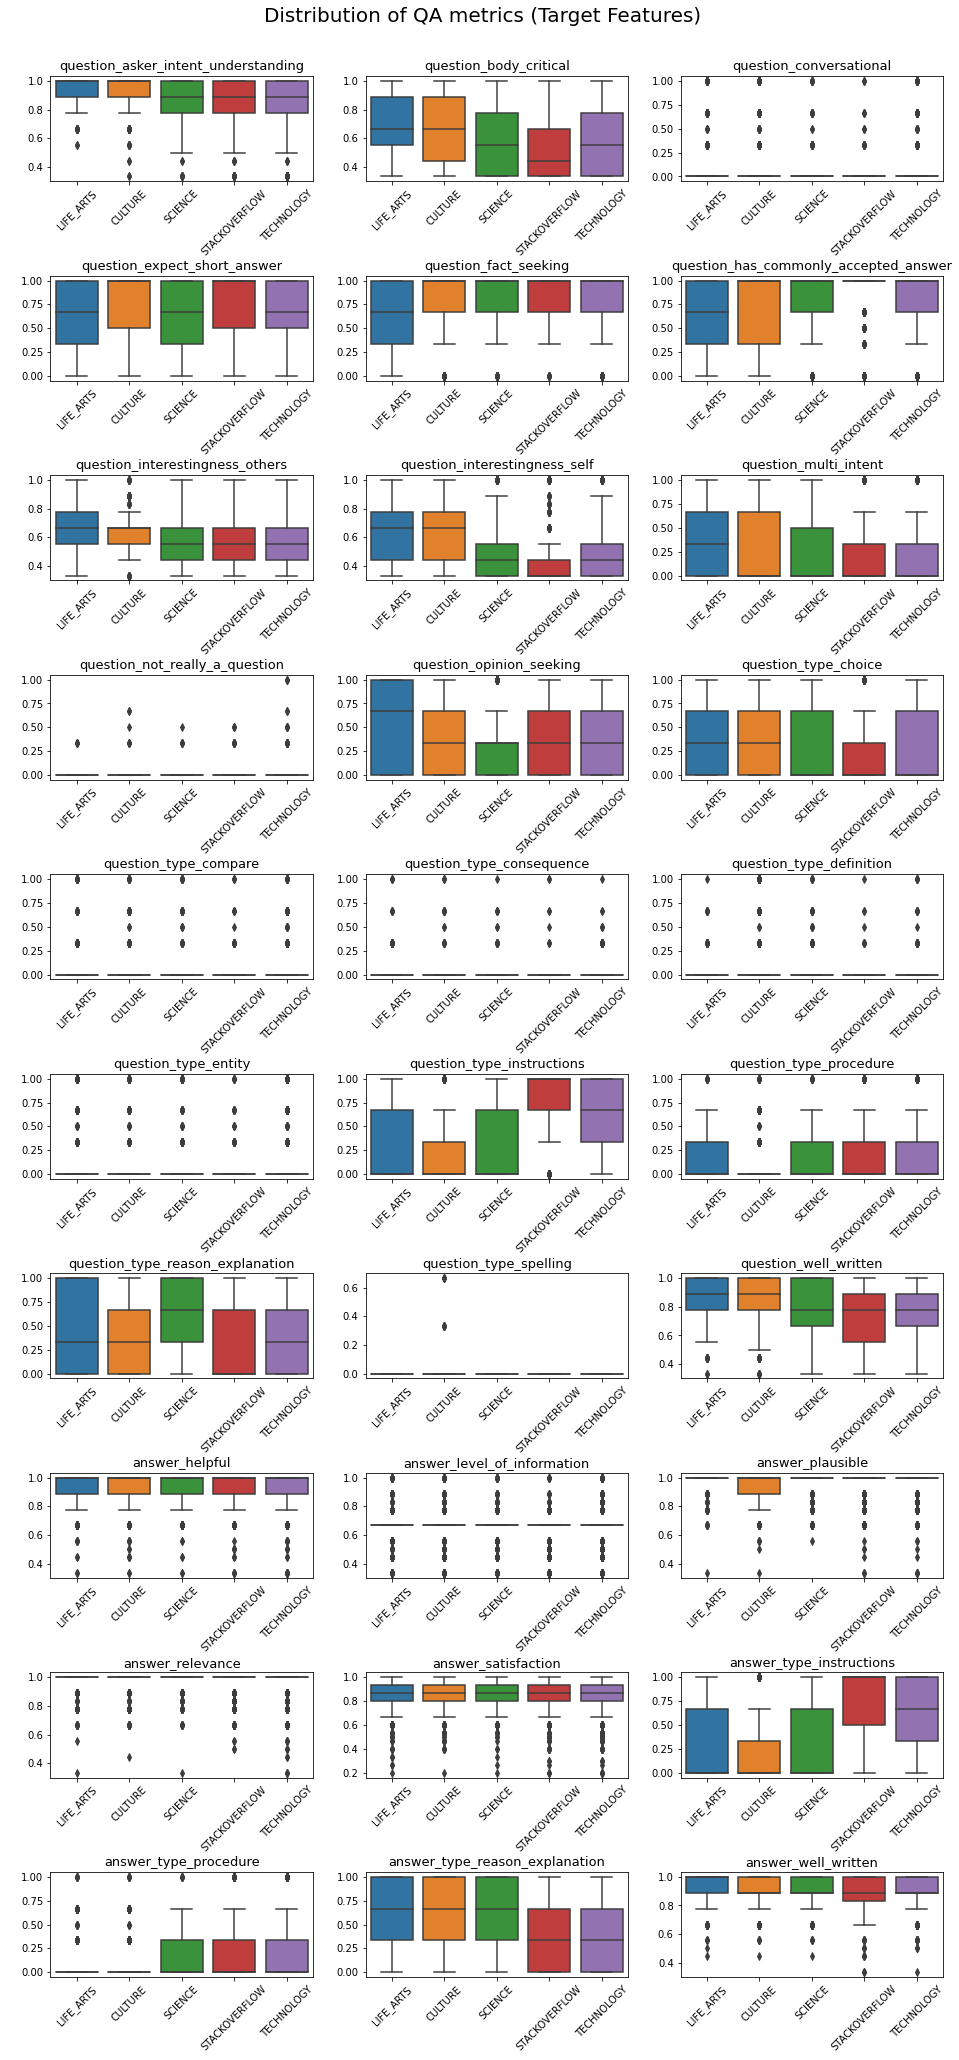

In [19]:
grid = gridspec.GridSpec(10, 3)

plt.figure(figsize=(16,8*4))
count=0
plt.suptitle('Distribution of QA metrics (Target Features)', size=20)
# top_host = df_train['host_cat'].value_counts()[:15].index
for n, col in enumerate(target_cols):
    #if df_train[target_cols].std()[col] > .15:
    ax = plt.subplot(grid[count])
    sns.boxplot(x='category', y=col, data=train_df)
    ax.set_title(str(col), fontsize=13)
    ax.set_xlabel('')
    ax.set_ylabel(' ')
    count+=1
    ax.set_xticklabels(ax.get_xticklabels(),rotation=45)

plt.subplots_adjust(top = 0.95, hspace=.9, wspace=.2)

plt.show()

<h3>Correlation Between Features</h3>

<AxesSubplot:>

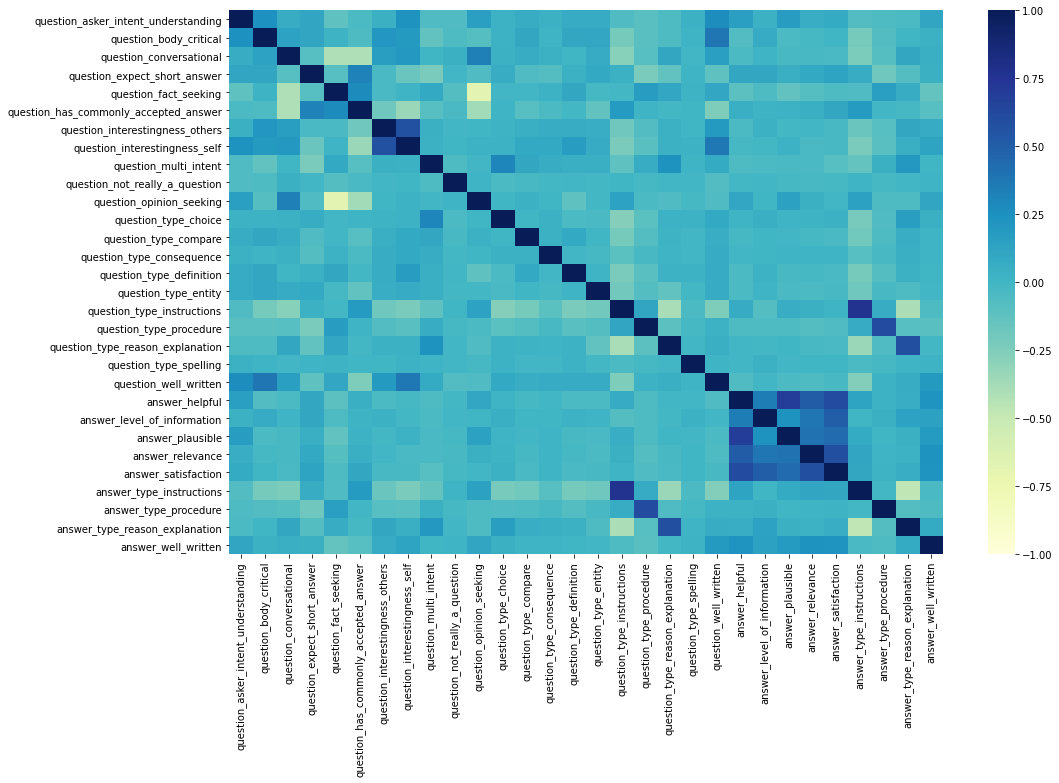

In [20]:
plt.figure(figsize=(16,10))
sns.heatmap(train_df[target_cols].corr(),vmin=-1,cmap='YlGnBu')

<div style="font-family:verdana; word-spacing:1.7px;">
We could see high correlation between Answer(Instructions,procedure,explanation) & Question(Instructions,procedure,explanation) respectively
    </div>

<h3>Question & Answer Texts</h3>

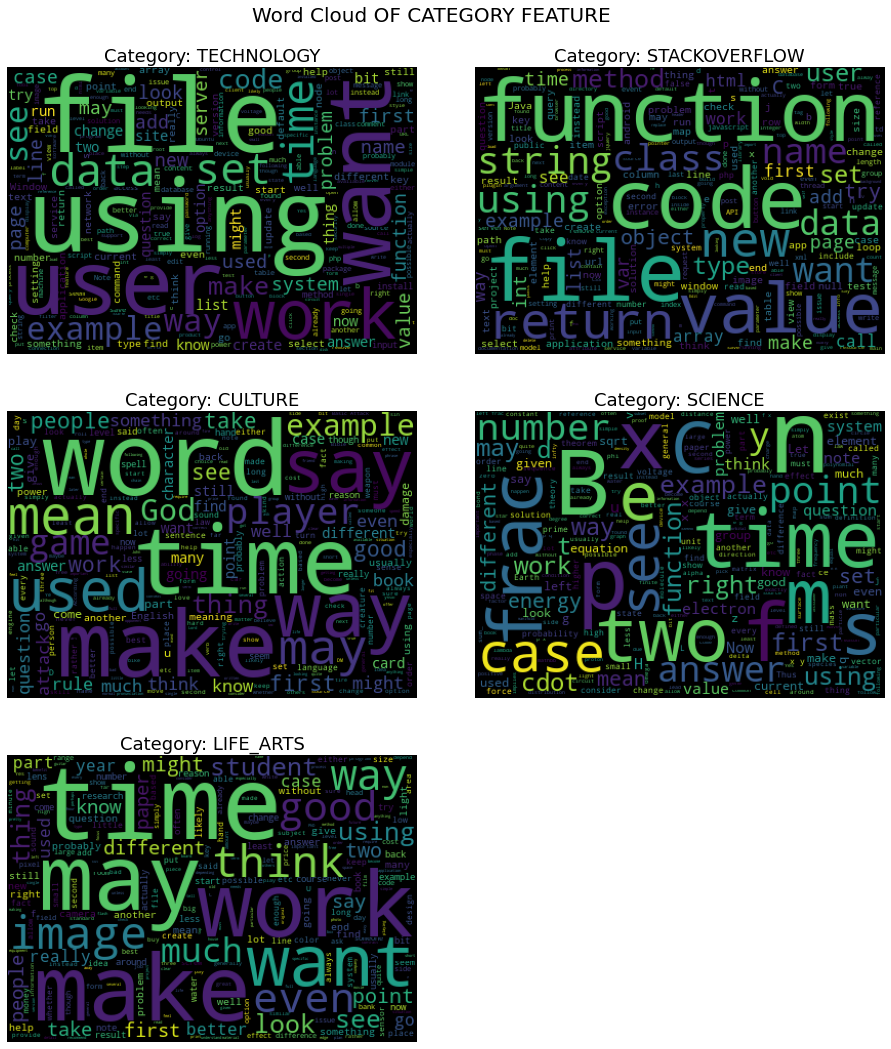

In [21]:
stopwords = set(STOPWORDS)
newStopWords = ['amp', 'gt', 'lt', 'div', 'id',
                'fi', 'will', 'use', 'one', 'nbsp', 'need']
stopwords.update(newStopWords)

grid = gridspec.GridSpec(5, 2)

plt.figure(figsize=(16,7*4))

plt.suptitle('Word Cloud OF CATEGORY FEATURE', size=20)

for n, col in enumerate(train_df['category'].value_counts().index):
    ax = plt.subplot(grid[n])  
    
    wordcloud = WordCloud(
        background_color='black',
        stopwords=stopwords,
        max_words=250,
        max_font_size=100, 
        width=400, height=280,
        random_state=42,
    ).generate(" ".join(train_df[train_df['category'] == col]['answer'].astype(str)))

    #print(wordcloud)

    plt.imshow(wordcloud)
    plt.title(f"Category: {col}",fontsize=18)
    plt.axis('off')
plt.subplots_adjust(top = 0.95, hspace=.2, wspace=.1 )

plt.show()

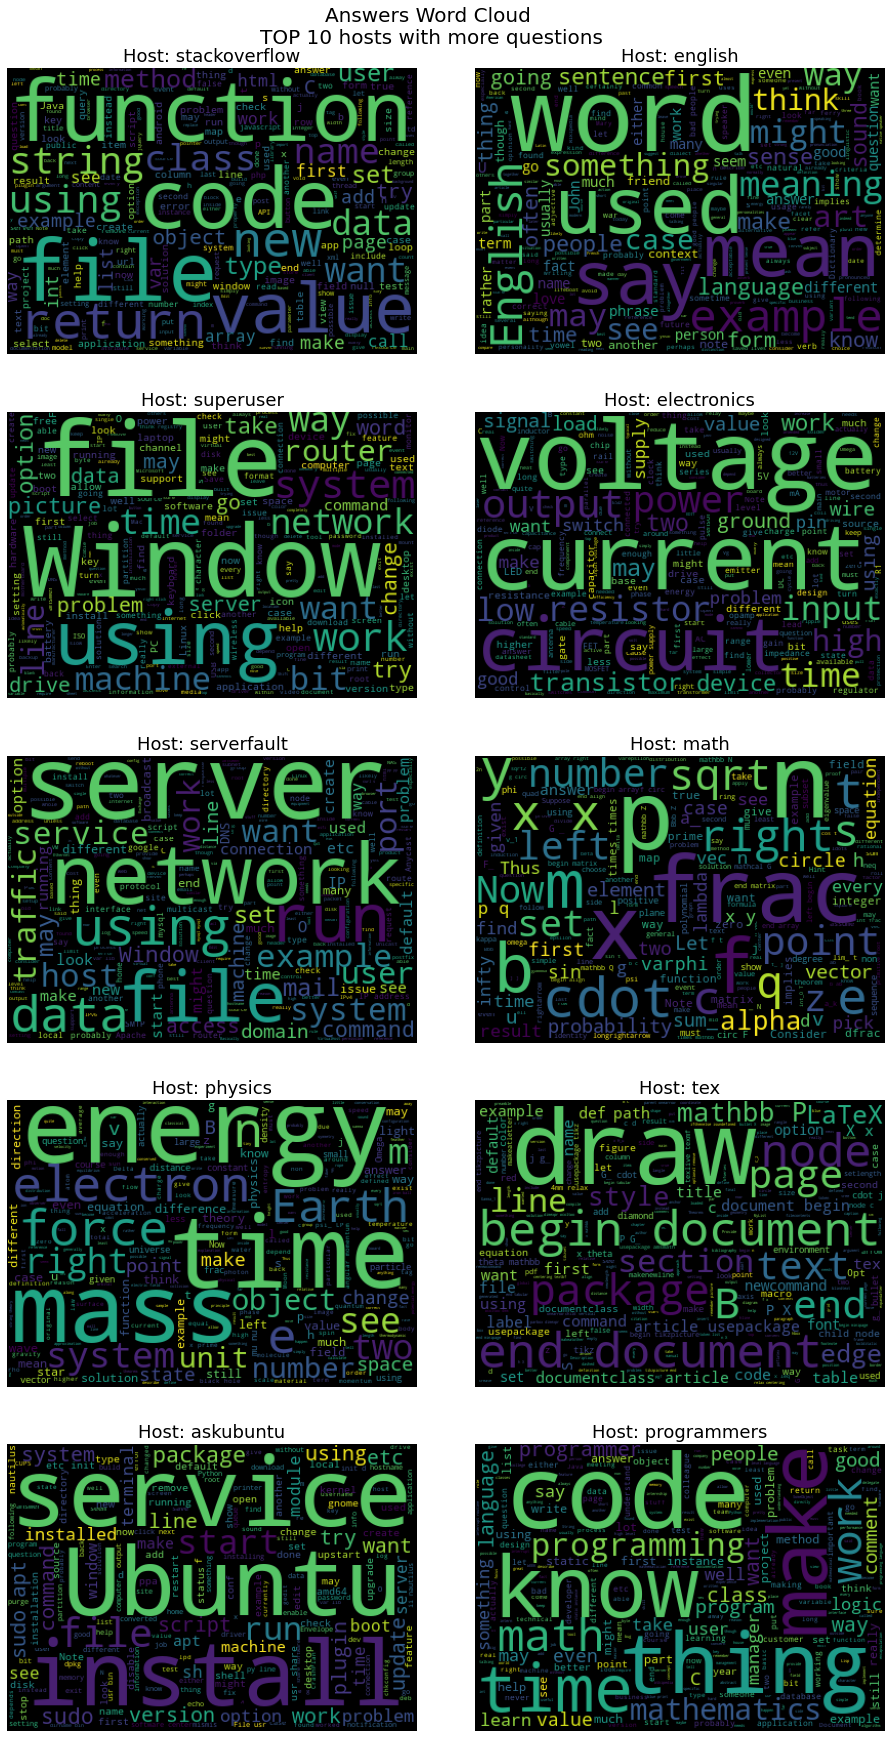

In [22]:
grid = gridspec.GridSpec(5, 2)

plt.figure(figsize=(16,7*4))

plt.suptitle('Answers Word Cloud \nTOP 10 hosts with more questions', size=20)

for n, col in enumerate(train_df['host_cat'].value_counts()[:10].index):
    ax = plt.subplot(grid[n])   
    wordcloud = WordCloud(
        background_color='black',
        stopwords=stopwords,
        max_words=250,
        max_font_size=100, 
        width=400, height=280,
        random_state=42,
    ).generate(" ".join(train_df[train_df['host_cat'] == col]['answer'].astype(str)))

    #print(wordcloud)

    plt.imshow(wordcloud)
    plt.title(f"Host: {col}",fontsize=18)
    plt.axis('off')
    
plt.subplots_adjust(top = 0.95, hspace=.2, wspace=.1 )

plt.show()

<h3>Sentiment Analysis</h3>

In [23]:
def polarity(text):
    if type(text) == str:
        return SIA.polarity_scores(text)
    else:
        return 1000
    
SIA = SentimentIntensityAnalyzer()
train_df["ans_polarity"] = train_df["answer"].progress_apply(polarity)

  0%|          | 0/6079 [00:00<?, ?it/s]

Calculate mean Sentiment values

In [24]:
# Calculate mean values of Sentiments
neg_vals, pos_vals, neutral_vals = [], [], []

for x_dict in train_df["ans_polarity"].values:
    neg_vals.append(x_dict['neg'])
    pos_vals.append(x_dict['pos'])
    neutral_vals.append(x_dict['neu'])

neg_vals = np.asarray(neg_vals)
pos_vals = np.asarray(pos_vals)
neutral_vals = np.asarray(neutral_vals)

mean_neg = neg_vals.mean()
mean_pos = pos_vals.mean()
mean_neu = neutral_vals.mean()

Negative Sentiment

In [25]:
neg_pol = [pols['neg'] for pols in train_df["ans_polarity"] if type(pols) is dict]
neg_pol = list(filter((0.0).__ne__, neg_pol))



trace = go.Histogram(x=neg_pol, marker=dict(
            color='lightseagreen')
    )
data = [trace]

layout = go.Layout(

    shapes= [{'line': {'color': '#FF0000', 'dash': 'solid', 'width': 1},
        'type': 'line',
        'x0': mean_neg,
        'x1': mean_neg,
        'xref': 'x',
        'y0': -0.1,
        'y1': 1,
        'yref': 'paper'}],

    # Annotations
    annotations=[dict(x=mean_neg,
                y=1,
                xref='x',
                yref='paper',
                text=f"Mean a = {np.round(mean_neg,3)}",
                showarrow=True,
                arrowhead=7,
                ax=1,
                ay=1,
            )]
)
fig = go.Figure(data=data, layout=layout)



fig.update_layout(xaxis_title="Negativity sentiment", 
                  title_text="Negativity sentiment", template="simple_white")
fig.show()

<div style="font-family:verdana; word-spacing:1.7px;">
From the above plot, we can see that negative sentiment has a strong rightward (positive) skew, indicating that negativity is usually on the lower side. This suggests that most comments are not toxic or negative. In fact, the most common negativity value is around <b>0.036</b>. Virtually no comments have a negativity greater than 0.35
    </div>

Positive Sentiment

In [26]:
pos_pol = [pols['pos'] for pols in train_df["ans_polarity"] if type(pols) is dict]
pos_pol = list(filter((0.0).__ne__, pos_pol))



trace = go.Histogram(x=pos_pol, marker=dict(
            color='lightsalmon')
    )
data = [trace]

layout = go.Layout(

    shapes= [{'line': {'color': 'seagreen', 'dash': 'solid', 'width': 1},
        'type': 'line',
        'x0': mean_pos,
        'x1': mean_pos,
        'xref': 'x',
        'y0': -0.1,
        'y1': 1,
        'yref': 'paper'}],

    # Annotations
    annotations=[dict(x=mean_pos,
                y=1,
                xref='x',
                yref='paper',
                text=f"Mean a = {np.round(mean_pos,3)}",
                showarrow=True,
                arrowhead=7,
                ax=1,
                ay=1,
            )]
)
fig = go.Figure(data=data, layout=layout)



fig.update_layout(xaxis_title="Positivity sentiment", 
                  title_text="Positivity sentiment", template="simple_white")
fig.show()

<div style="font-family:verdana; word-spacing:1.7px;">
After comparing with Negativity, the answers have slightly greater positivity
    </div>

In [27]:
neu_pol = [pols['neu'] for pols in train_df["ans_polarity"] if type(pols) is dict]
neu_pol = list(filter((0.0).__ne__, neu_pol))



trace = go.Histogram(x=neu_pol, marker=dict(
            color='lightskyblue')
    )
data = [trace]

layout = go.Layout(

    shapes= [{'line': {'color': 'lightsalmon', 'dash': 'solid', 'width': 1},
        'type': 'line',
        'x0': mean_neu,
        'x1': mean_neu,
        'xref': 'x',
        'y0': -0.1,
        'y1': 1,
        'yref': 'paper'}],

    # Annotations
    annotations=[dict(x=mean_neu,
                y=1,
                xref='x',
                yref='paper',
                text=f"Mean a = {np.round(mean_neu,3)}",
                showarrow=True,
                arrowhead=7,
                ax=1,
                ay=1,
            )]
)
fig = go.Figure(data=data, layout=layout)



fig.update_layout(xaxis_title="Neutral sentiment", 
                  title_text="Neutral sentiment", template="simple_white")
fig.show()

<div style="font-family:verdana; word-spacing:1.7px;">
    It is clear that as positivity & Negativity are low we have high neutral answers with mean value 0.88
    </div>

<h3>Readability</h3>
<div style="font-family:verdana; word-spacing:1.7px;">
Readability is an indication of how "easy" it is to read some text. There are several metrics that can be used to measure the readability of a piece of text, including Flesch reading ease, automated readability, and Dale-Chall readability.
    </div>

In [28]:
train_df["flesch_reading_ease"] = train_df["answer"].progress_apply(textstat.flesch_reading_ease)
#train_df["automated_readability"] = train_df["answer"].progress_apply(textstat.automated_readability_index)
#train_df["dale_chall_readability"] = train_df["answer"].progress_apply(textstat.dale_chall_readability_score)

  0%|          | 0/6079 [00:00<?, ?it/s]

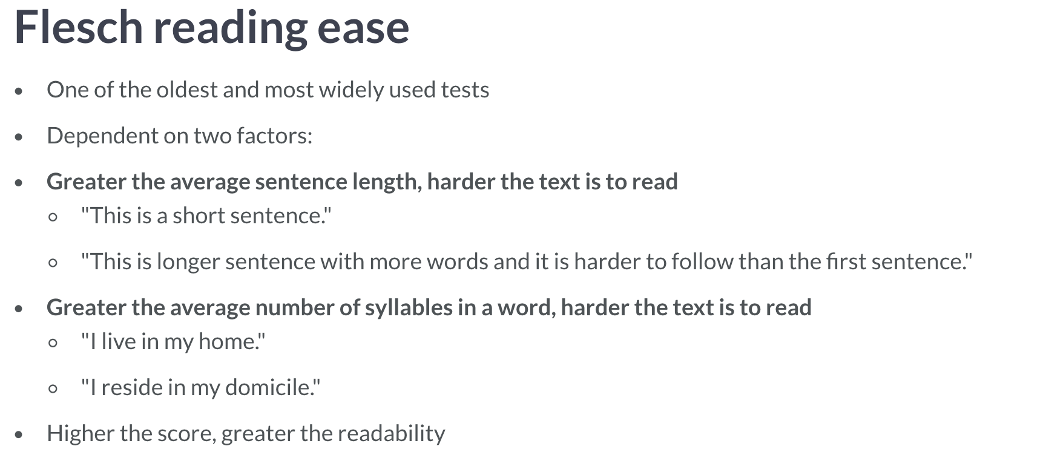

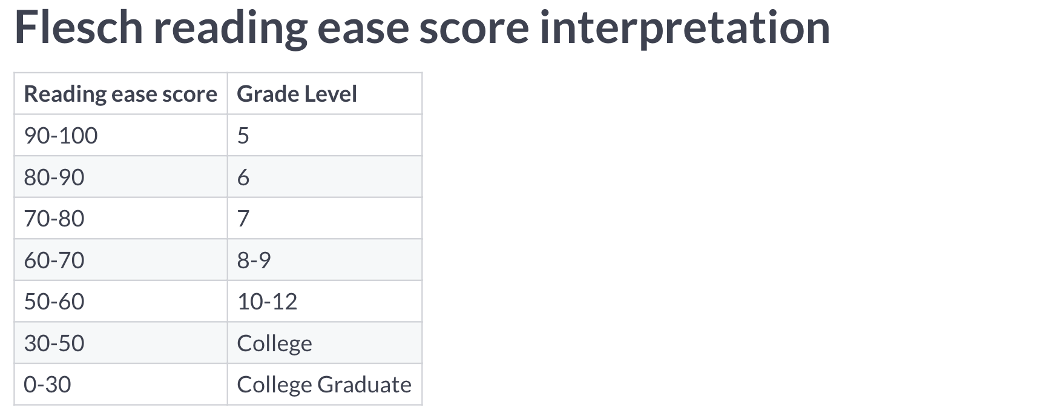

In [29]:
fig = go.Figure(go.Histogram(x=train_df.query("flesch_reading_ease > 0")["flesch_reading_ease"], marker=dict(
            color='darkorange')
    ))

fig.update_layout(xaxis_title="Flesch reading ease", title_text="Flesch reading ease", 
                  template="simple_white")
fig.show()

<div style="font-family:verdana; word-spacing:1.7px;">
    We have a Gaussian Distribution of Scores ranging from very simple to complex readablity, Let's have a deeper look into the reading scores of different categories to understand more clearly
    </div>

In [30]:
fig = go.Figure()

for category, color in zip(set(train_df['category'].values), ['#636EFA', '#EF553B', '#00CC96', '#AB63FA', '#FFA15A']):
    fig.add_trace(go.Histogram(name = category, x=train_df.query(f"flesch_reading_ease > 0 and category == '{category}'")["flesch_reading_ease"], marker=dict(
                color=color)))
    

fig.update_layout(xaxis_title="Flesch reading ease", title_text="Flesch reading ease", 
                  template="simple_white", barmode='overlay')

fig.update_traces(opacity=0.6)
fig.show()

<div style="font-family:verdana; word-spacing:1.7px;">
All the different categories show similar distribution indicating that the answers given do not have fixed complexity based on category.
    </div>

<h3>Preprocessing </h3>

In [31]:
train_df.columns

Index(['qa_id', 'question_title', 'question_body', 'question_user_name',
       'question_user_page', 'answer', 'answer_user_name', 'answer_user_page',
       'url', 'category', 'question_asker_intent_understanding',
       'question_body_critical', 'question_conversational',
       'question_expect_short_answer', 'question_fact_seeking',
       'question_has_commonly_accepted_answer',
       'question_interestingness_others', 'question_interestingness_self',
       'question_multi_intent', 'question_not_really_a_question',
       'question_opinion_seeking', 'question_type_choice',
       'question_type_compare', 'question_type_consequence',
       'question_type_definition', 'question_type_entity',
       'question_type_instructions', 'question_type_procedure',
       'question_type_reason_explanation', 'question_type_spelling',
       'question_well_written', 'answer_helpful',
       'answer_level_of_information', 'answer_plausible', 'answer_relevance',
       'answer_satisfaction', 

In [32]:
extra_cols = ['host_cat', 'question_n_words', 'ans_polarity', 'flesch_reading_ease']

y_train = train_df[target_cols].copy()
X_train = train_df.drop(list(extra_cols) + list(target_cols), axis=1)
del train_df

X_test = test_df.copy()
del test_df

gc.collect()

1501

<h3><center>4. Bert Tokenizer</center></h3>

In [33]:
from transformers import BertTokenizer, TFBertModel
from tokenizers import BertWordPieceTokenizer


np.set_printoptions(suppress=True)

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = TFBertModel.from_pretrained("bert-base-uncased")

save_path = '/kaggle/working/bert_base_uncased/'
if not os.path.exists(save_path):
    os.makedirs(save_path)
tokenizer.save_pretrained(save_path)

'''fast_tokenizer = BertWordPieceTokenizer('bert_base_uncased/vocab.txt', 
                                        lowercase=True)'''

fast_tokenizer = BertTokenizer('bert_base_uncased/vocab.txt', 
                                        lowercase=True)


Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/433 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/536M [00:00<?, ?B/s]

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


<h3>Preprocessing Data to Bert Architecture</h3>

In [34]:
MAX_SEQUENCE_LENGTH = 512

def _convert_to_transformer_inputs(title, question, answer, tokenizer, max_sequence_length):
    """Converts tokenized input to ids, masks and segments for transformer (including bert)"""
    
    def return_id(str1, str2, truncation_strategy, length):

        inputs = tokenizer.encode_plus(str1, str2,
            add_special_tokens=True,
            max_length=length,
            truncation_strategy=truncation_strategy)
        
        input_ids =  inputs["input_ids"]
        input_masks = [1] * len(input_ids)
        input_segments = inputs["token_type_ids"]
        padding_length = length - len(input_ids)
        padding_id = tokenizer.pad_token_id
        input_ids = input_ids + ([padding_id] * padding_length)
        input_masks = input_masks + ([0] * padding_length)
        input_segments = input_segments + ([0] * padding_length)
        
        return [input_ids, input_masks, input_segments]
    
    input_ids_q, input_masks_q, input_segments_q = return_id(
        title + ' ' + question, None, 'longest_first', max_sequence_length)
    
    input_ids_a, input_masks_a, input_segments_a = return_id(
        answer, None, 'longest_first', max_sequence_length)
    
    return [input_ids_q, input_masks_q, input_segments_q,
            input_ids_a, input_masks_a, input_segments_a]

# Computing the inputs
def compute_input_arrays(df, columns, tokenizer, max_sequence_length):
    
    input_ids_q, input_masks_q, input_segments_q = [], [], []
    input_ids_a, input_masks_a, input_segments_a = [], [], []
    
    for _, instance in tqdm(df[columns].iterrows()):
        
        t, q, a = instance.question_title, instance.question_body, instance.answer

        ids_q, masks_q, segments_q, ids_a, masks_a, segments_a = \
        _convert_to_transformer_inputs(t, q, a, tokenizer, max_sequence_length)
        
        input_ids_q.append(ids_q)
        input_masks_q.append(masks_q)
        input_segments_q.append(segments_q)

        input_ids_a.append(ids_a)
        input_masks_a.append(masks_a)
        input_segments_a.append(segments_a)
        
    return [np.asarray(input_ids_q, dtype=np.int32), 
            np.asarray(input_masks_q, dtype=np.int32), 
            np.asarray(input_segments_q, dtype=np.int32),
            np.asarray(input_ids_a, dtype=np.int32), 
            np.asarray(input_masks_a, dtype=np.int32), 
            np.asarray(input_segments_a, dtype=np.int32)]


def compute_output_arrays(df, columns):
    return np.asarray(df[columns])

<h3><center>5. Creating Model</center></h3>

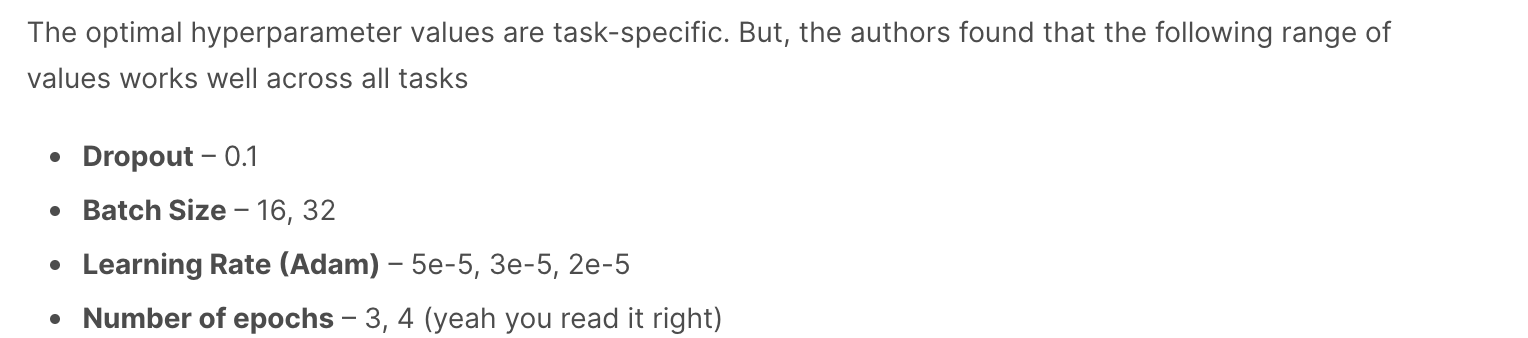

In [35]:
## Computing the error metric to the model optimization
def compute_spearmanr_ignore_nan(trues, preds):
    rhos = []
    for tcol, pcol in zip(np.transpose(trues), np.transpose(preds)):
        rhos.append(spearmanr(tcol, pcol).correlation)
    return np.nanmean(rhos)

def create_model():
    q_id = tf.keras.layers.Input((MAX_SEQUENCE_LENGTH,), dtype=tf.int32)
    a_id = tf.keras.layers.Input((MAX_SEQUENCE_LENGTH,), dtype=tf.int32)
    
    q_mask = tf.keras.layers.Input((MAX_SEQUENCE_LENGTH,), dtype=tf.int32)
    a_mask = tf.keras.layers.Input((MAX_SEQUENCE_LENGTH,), dtype=tf.int32)
    
    q_atn = tf.keras.layers.Input((MAX_SEQUENCE_LENGTH,), dtype=tf.int32)
    a_atn = tf.keras.layers.Input((MAX_SEQUENCE_LENGTH,), dtype=tf.int32)
    
    #config = BertConfig() # print(config) to see settings
    #config.output_hidden_states = False # Set to True to obtain hidden states
    # caution: when using e.g. XLNet, XLNetConfig() will automatically use xlnet-large config
    
    # normally ".from_pretrained('bert-base-uncased')", but because of no internet, the 
    # pretrained model has been downloaded manually and uploaded to kaggle. 
    
    
    bert_model = TFBertModel.from_pretrained('bert-base-uncased')
    
    # if config.output_hidden_states = True, obtain hidden states via bert_model(...)[-1]
    q_embedding = bert_model(q_id, attention_mask=q_mask, 
                             token_type_ids=q_atn)[0]
    a_embedding = bert_model(a_id, attention_mask=a_mask, 
                             token_type_ids=a_atn)[0]
    
    q = tf.keras.layers.GlobalAveragePooling1D()(q_embedding)
    a = tf.keras.layers.GlobalAveragePooling1D()(a_embedding)
    
    x = tf.keras.layers.Concatenate()([q, a])
    
    x = tf.keras.layers.Dropout(0.2)(x)
    
    x = tf.keras.layers.Dense(30, activation='sigmoid')(x)

    model = tf.keras.models.Model(inputs=[q_id, q_mask, q_atn, a_id, a_mask, a_atn,], outputs=x)
    
    return model

In [36]:
outputs = compute_output_arrays(y_train, y_train.columns)

inputs = compute_input_arrays(X_train, X_train.columns, 
                              fast_tokenizer, MAX_SEQUENCE_LENGTH)

test_inputs = compute_input_arrays(X_test, X_test.columns, 
                                   fast_tokenizer, MAX_SEQUENCE_LENGTH)


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.

13it [00:00, 99.33it/s]
23it [00:00, 91.77it/s]
33it [00:00, 78.80it/s]
46it [00:00, 94.69it/s]
57it [00:00, 99.16it/s]
68it [00:00, 88.37it/s]
79it [00:00, 91.99it/s]
89it [00:00, 87.84it/s]
98it [00:01, 82.39it/s]
109it [00:01, 88.48it/s]
121it [00:01, 96.63it/s]
131it [00:01, 89.60it/s]
141it [00:01, 92.26it/s]
153it [00:01, 96.62it/s]
163it [00:01, 89.25it/s]
173it [00:01, 91.60it/s]
185it [00:02, 98.70it/s]
196it [00:02, 97.99it/s]
207it [00:02, 101.08it/s]
218it [00:02, 102.99it/s]
229it [00:02, 95.34it/s] 
242it [00:02, 103.99it/s]
253it [00:02, 99.84it/s] 
264it [00:02, 100.37it/s]
275it [00:

<h3><center>6. Training Model</center></h3>

In [37]:
## Creating Kfold with 10 splits 
gkf = GroupKFold(n_splits=10).split(X=X_train.question_body, groups=X_train.question_body)

## to receive predictions
valid_preds = []
test_preds = []

## Looping throught the folds
for fold, (train_idx, valid_idx) in enumerate(gkf):
    
    # Train for particular folds(used for training for less folds for testing)
    if fold in np.arange(10):  #[0, 1, 2]
        
        ## Train index from Kfold 
        train_inputs = [inputs[i][train_idx] for i in range(len(inputs))]
        train_outputs = outputs[train_idx]
        ## Valid index from Kfold 
        valid_inputs = [inputs[i][valid_idx] for i in range(len(inputs))]
        valid_outputs = outputs[valid_idx]
        
        K.clear_session()
        
        ## Instantiating the Bert Model
        model = create_model()
        optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5)
        model.compile(loss='binary_crossentropy', optimizer=optimizer)
        
        ## Fiting the model
        model.fit(train_inputs, train_outputs, epochs=2, batch_size=6)
        
        # model.save_weights(f'bert-{fold}.h5')
        valid_preds.append(model.predict(valid_inputs))
        # predicting the test set and appending to test_preds
        test_preds.append(model.predict(test_inputs))
        
        # Calculating the error in the valid set
        rho_val = compute_spearmanr_ignore_nan(valid_outputs, valid_preds[-1])
        print('validation score = ', rho_val)

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Epoch 1/2
912/912 [==============================] - 801s 846ms/step - loss: 0.4186
Epoch 2/2
912/912 [==============================] - 772s 846ms/step - loss: 0.3677
validation score =  0.4113217349321523


Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Epoch 1/2
912/912 [==============================] - 801s 847ms/step - loss: 0.4184
Epoch 2/2
912/912 [==============================] - 772s 846ms/step - loss: 0.3667
validation score =  0.4024340883140593


Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Epoch 1/2
912/912 [==============================] - 802s 847ms/step - loss: 0.4198
Epoch 2/2
912/912 [==============================] - 773s 848ms/step - loss: 0.3677
validation score =  0.3891183334833309


Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Epoch 1/2
912/912 [==============================] - 803s 848ms/step - loss: 0.4216
Epoch 2/2
912/912 [==============================] - 774s 849ms/step - loss: 0.3693
validation score =  0.36957485202456797


Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Epoch 1/2
912/912 [==============================] - 803s 849ms/step - loss: 0.4216
Epoch 2/2
912/912 [==============================] - 775s 849ms/step - loss: 0.3664
validation score =  0.3786892210210963


Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Epoch 1/2
912/912 [==============================] - 803s 850ms/step - loss: 0.4175
Epoch 2/2
912/912 [==============================] - 775s 850ms/step - loss: 0.3671
validation score =  0.36956814222743056


Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Epoch 1/2
912/912 [==============================] - 804s 850ms/step - loss: 0.4166
Epoch 2/2
912/912 [==============================] - 775s 849ms/step - loss: 0.3636
validation score =  0.381372180135877


Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Epoch 1/2
912/912 [==============================] - 804s 850ms/step - loss: 0.4194
Epoch 2/2
912/912 [==============================] - 773s 848ms/step - loss: 0.3687
validation score =  0.3935273102148136


Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Epoch 1/2
912/912 [==============================] - 803s 848ms/step - loss: 0.4155
Epoch 2/2
912/912 [==============================] - 774s 848ms/step - loss: 0.3641
validation score =  0.3893771594387431


Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Epoch 1/2
912/912 [==============================] - 771s 827ms/step - loss: 0.4221
Epoch 2/2
912/912 [==============================] - 754s 827ms/step - loss: 0.3673
validation score =  0.4080169746450978


<h3><center>7. Predicting Data</center></h3>

In [38]:
columns = list(y_train.columns)
y = valid_outputs[:10]
y_pred = model.predict(valid_inputs)

In [39]:
print('Actual output')
pd.DataFrame(data=y, columns=columns)

Actual output


question_asker_intent_understanding  question_body_critical  \
0                             0.833333                0.666667   
1                             1.000000                0.333333   
2                             1.000000                0.888889   
3                             1.000000                0.888889   
4                             0.888889                0.333333   
5                             0.888889                0.666667   
6                             0.888889                0.444444   
7                             0.888889                0.333333   
8                             1.000000                0.333333   
9                             1.000000                0.777778   

   question_conversational  question_expect_short_answer  \
0                 0.000000                      1.000000   
1                 0.000000                      1.000000   
2                 0.000000                      0.666667   
3                 0.000000                      1.000000   
4                 0.000000                      0.666667   
5                 0.000000                      0.666667   
6                 0.000000                      1.000000   
7                 0.000000                      0.666667   
8                 0.000000                      0.666667   
9                 0.333333                      0.666667   

   question_fact_seeking  question_has_commonly_accepted_answer  \
0               1.000000                               1.000000   
1               0.333333                               1.000000   
2               0.666667                               1.000000   
3               0.666667                               1.000000   
4               0.333333                               0.666667   
5               0.666667                               1.000000   
6               1.000000                               1.000000   
7               0.333333                               0.666667   
8               0.666667                               1.000000   
9               0.666667                               0.333333   

   question_interestingness_others  question_interestingness_self  \
0                         0.666667                       0.500000   
1                         0.444444                       0.444444   
2                         0.444444                       0.444444   
3                         0.777778                       0.555556   
4                         0.555556                       0.444444   
5                         0.444444                       0.333333   
6                         0.666667                       0.666667   
7                         0.555556                       0.444444   
8                         0.444444                       0.444444   
9                         0.888889                       0.777778   

   question_multi_intent  question_not_really_a_question  ...  \
0               0.000000                             0.0  ...   
1               0.000000                             0.0  ...   
2               0.333333                             0.0  ...   
3               0.000000                             0.0  ...   
4               0.000000                             0.0  ...   
5               0.000000                             0.0  ...   
6               0.333333                             0.0  ...   
7               0.000000                             0.0  ...   
8               0.000000                             0.0  ...   
9               0.000000                             0.0  ...   

   question_well_written  answer_helpful  answer_level_of_information  \
0               0.666667        0.666667                     0.500000   
1               0.666667        0.888889                     0.555556   
2               0.888889        0.888889                     0.666667   
3               0.888889        1.000000                     0.666667   
4               0.666667        1.00

In [40]:
print('Predicted output')
pd.DataFrame(data=y_pred[:10], columns=columns)

Predicted output


question_asker_intent_understanding  question_body_critical  \
0                             0.945503                0.670306   
1                             0.882456                0.552885   
2                             0.961491                0.673064   
3                             0.958106                0.788414   
4                             0.835187                0.435602   
5                             0.944134                0.777012   
6                             0.857662                0.437816   
7                             0.865880                0.475086   
8                             0.867295                0.441695   
9                             0.950365                0.725020   

   question_conversational  question_expect_short_answer  \
0                 0.024535                      0.663892   
1                 0.021118                      0.666157   
2                 0.023624                      0.738049   
3                 0.007544                      0.813572   
4                 0.014641                      0.709614   
5                 0.201331                      0.799117   
6                 0.027382                      0.773072   
7                 0.023454                      0.765630   
8                 0.058795                      0.556392   
9                 0.380506                      0.905035   

   question_fact_seeking  question_has_commonly_accepted_answer  \
0               0.767231                               0.726603   
1               0.628745                               0.751967   
2               0.923821                               0.916624   
3               0.832723                               0.897195   
4               0.623542                               0.839996   
5               0.520643                               0.738563   
6               0.749948                               0.863562   
7               0.698946                               0.746636   
8               0.594194                               0.719509   
9               0.164506                               0.176457   

   question_interestingness_others  question_interestingness_self  \
0                         0.649182                       0.560376   
1                         0.604679                       0.476169   
2                         0.714237                       0.582643   
3                         0.616062                       0.583709   
4                         0.533118                       0.444053   
5                         0.707022                       0.615175   
6                         0.579913                       0.396788   
7                         0.520663                       0.483319   
8                         0.665915                       0.530380   
9                         0.661154                       0.692106   

   question_multi_intent  question_not_really_a_question  ...  \
0               0.358483                        0.003518  ...   
1               0.122004                        0.010254  ...   
2               0.576037                        0.002736  ...   
3               0.034637                        0.001932  ...   
4               0.085197                        0.008639  ...   
5               0.185164                        0.002820  ...   
6               0.296072                        0.004987  ...   
7               0.038191                        0.004110  ...   
8               0.450240                        0.006483  ...   
9               0.068613                        0.006666  ...   

   question_well_written  answer_helpful  answer_level_of_information  \
0               0.881001        0.916133                     0.590285   
1               0.731632        0.919648                     0.552666   
2               0.865715        0.942006                     0.685765   
3               0.873382        0.963855                     0.735060   
4               0.662175        0.95